In [1]:
#!/usr/bin/env python3

import accelerate
import torch
from torch.utils import data
from torchvision import transforms

import k_diffusion as K
from train_openai import OpenAIDenoiser


def to_show(x: torch.Tensor, ref=None):
    x = x[0].permute(1, 2, 0)
    if ref is None:
        x_min, x_max = x.min(), x.max()
    else:
        x_min, x_max = ref.min(), ref.max()
    x = (x - x_min) / (x_max - x_min)
    return x.detach().cpu().numpy()


In [2]:
class Args:
    config = "configs/test_ffhq_dwt.json"
    checkpoint = "../model_zoo/ffhq_dwt.ckpt"

args = Args()

config = K.config.load_config(open(args.config))
model_config = config['model']
dataset_config = config['dataset']
size = model_config['input_size']

accelerator = accelerate.Accelerator()
device = accelerator.device
print(f'Using device: {device}', flush=True)

model = OpenAIDenoiser.load_from_checkpoint(args.checkpoint, map_location='cpu')
print(model.model_config)
model = model.model

# test data
tf = transforms.Compose([
    transforms.ToTensor(),
    lambda x: x * 2 - 1
])
test_set = K.utils.FolderOfImages(dataset_config['location'], transform=tf)
test_dl = data.DataLoader(test_set, batch_size=1)

test_dl, model = accelerator.prepare(test_dl, model)
test_dl = iter(test_dl)

Using device: cpu
{'type': 'openai_ffhq', 'input_channels': 3, 'input_size': [256, 256], 'augment_prob': 0.12, 'sigma_min': '1e-2', 'sigma_max': 160, 'sigma_data': 0.5, 'sigma_sample_density': {'type': 'cosine'}, 'openai': {'num_channels': 128, 'num_res_blocks': 1, 'attention_resolutions': '16'}, 'ortho_tf_type': 'dwt'}


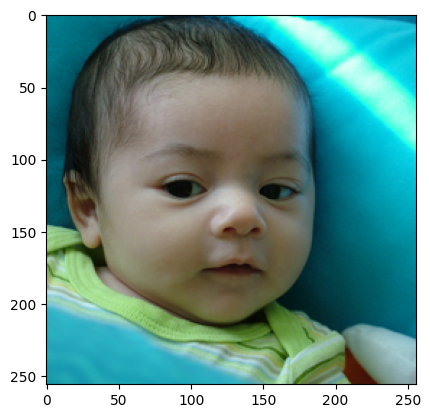

In [3]:
import matplotlib.pyplot as plt

x0, = next(test_dl)
plt.imshow(to_show(x0))

0.006459527183324099 0.00019277393585070968
0.006903513800352812 4.233567597111687e-05
0.006459525786340237 0.0014811273431405425
0.006019920576363802 0.0003369276528246701


Text(0.5, 1.0, 'DWT Variance')

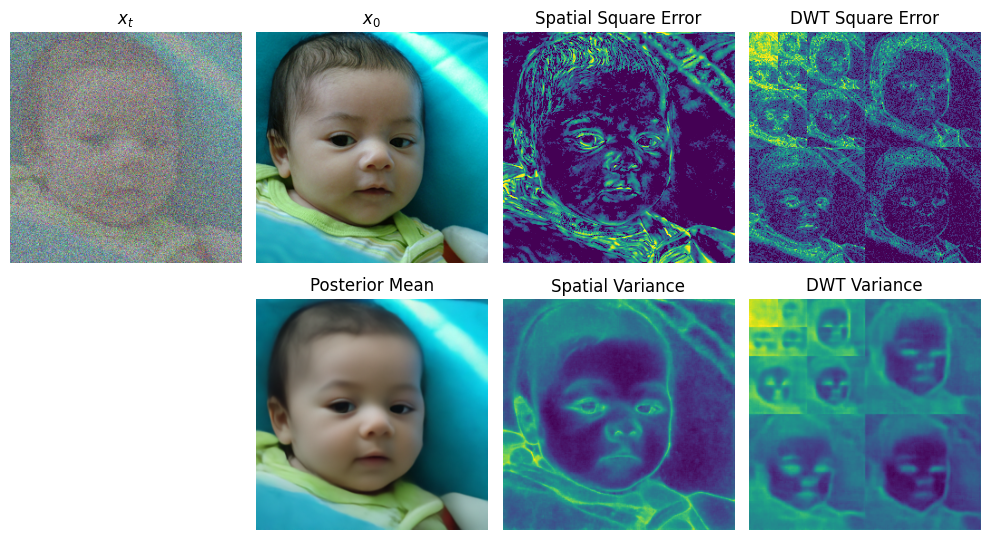

In [6]:
sigma_min = model_config['sigma_min']
sigma_max = model_config['sigma_max']
sigmas = K.sampling.get_sigmas_karras(50, sigma_min, sigma_max, rho=7., device=device)
x0 = x0.to(device)

sigma = torch.Tensor([1]).to(device)
x = x0 + torch.randn_like(x0) * sigma
x = x.requires_grad_()

model_output, logvar, logvar_ot = model(x, sigma, return_variance=True)
c_out, c_in = model.get_scalings(sigma)
ot = model.ortho_tf

x0_mean = model_output * c_out + x

error = (x0_mean - x0).pow(2).mean(dim=1, keepdim=True)
error_pred = (logvar.exp() * c_out.pow(2)).mean(dim=1, keepdim=True)

error_ot = (ot(x0_mean) - ot(x0)).pow(2).mean(dim=1, keepdim=True)
error_ot_pred = (logvar_ot.exp() * c_out.pow(2)).mean(dim=1, keepdim=True)

print(error.mean().item(), error.var().item())
print(error_pred.mean().item(), error_pred.var().item())

print(error_ot.mean().item(), error_ot.var().item())
print(error_ot_pred.mean().item(), error_ot_pred.var().item())


fig, axes = plt.subplots(2, 4, figsize=(10, 5.5))
for ax in axes.flatten():
    ax.axis('off')
plt.tight_layout()

axes[0, 0].imshow(to_show(x), vmin=0, vmax=1)
axes[0, 0].set_title(rf"$x_t$")

axes[0, 1].imshow(to_show(x0))
axes[0, 1].set_title(rf"$x_0$")

axes[1, 1].imshow(to_show(x0_mean))
axes[1, 1].set_title(rf"Posterior Mean")

axes[0, 2].imshow(to_show(error.log(), ref=error_pred.log()), vmin=0, vmax=1)
axes[0, 2].set_title(rf"Spatial Square Error")

axes[1, 2].imshow(to_show(error_pred.log()), vmin=0, vmax=1)
axes[1, 2].set_title(rf"Spatial Variance")

axes[0, 3].imshow(to_show(error_ot.log(), ref=error_ot_pred.log()), vmin=0, vmax=1)
axes[0, 3].set_title(rf"DWT Square Error")

axes[1, 3].imshow(to_show(error_ot_pred.log()), vmin=0, vmax=1)
axes[1, 3].set_title(rf"DWT Variance")
